# Objetivo

Desarrollo Parcial practico - Aprendizaje automatico III - ICESI

# Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
- La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 30 de junio a las 23:59  para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

## El Problema

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde junio de 2014.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

# Lectura de paquetes

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro
import statsmodels.api as sm
from matplotlib import pyplot as plt  # gráficos

import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
import optuna

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from src.ml_utils import *
from src.plot_utils import *

# colocar estilo fondo blanco
plt.style.use("default")

/opt/homebrew/Caskroom/miniconda/base/envs/maestria/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Lectura de data

In [2]:
df = pd.read_csv("Examen.csv").iloc[:,1:]

# Crear un rango de fechas mensuales desde junio 2014 por 127 meses
fechas = pd.date_range(start="2014-06-01", periods=127, freq="MS")
df.index = fechas
df.index.name = "fecha"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2014-06-01 to 2024-12-01
Freq: MS
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   producto1  127 non-null    float64
 1   producto2  127 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


# Analisis Exploratorio (EDA)

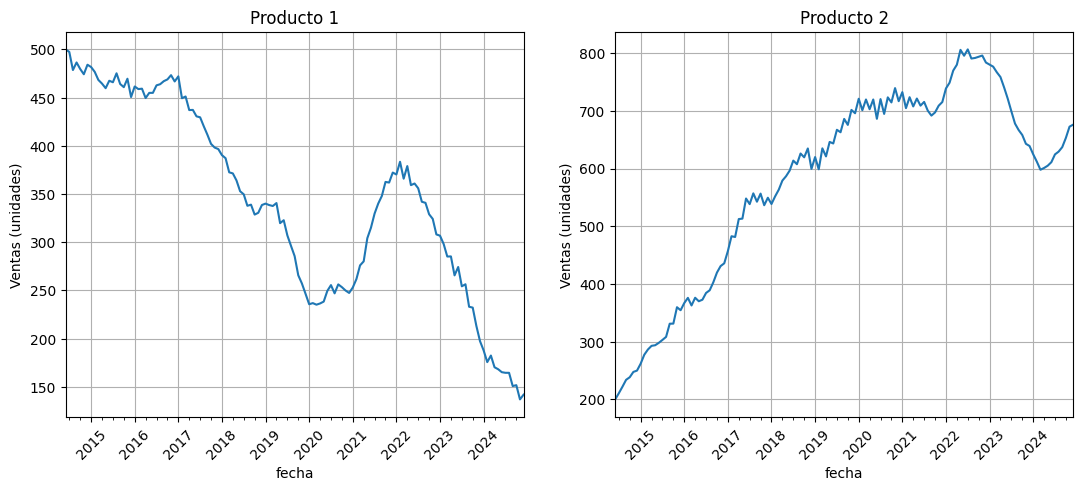

In [4]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
df["producto1"].plot()
plt.title("Producto 1")
plt.ylabel("Ventas (unidades)")
plt.xticks(rotation=45)
plt.grid()

plt.subplot(1,2,2)
df["producto2"].plot()
plt.title("Producto 2")
plt.ylabel("Ventas (unidades)")
plt.xticks(rotation=45)
plt.grid()

## Descomposición STL

In [5]:
# Descomposición STL de ambas series

stl_producto1 = STL(df["producto1"], seasonal=13)
stl_producto2 = STL(df["producto2"], seasonal=13)
result_producto1 = stl_producto1.fit()
result_producto2 = stl_producto2.fit()

df["producto1_trend"] = result_producto1.trend
df["producto1_seasonal"] = result_producto1.seasonal
df["producto2_trend"] = result_producto2.trend
df["producto2_seasonal"] = result_producto2.seasonal

# graficar usando plotly
graficar_serie_con_descomposicion(df, "producto #1", "producto1")
graficar_serie_con_descomposicion(df, "producto #2", "producto2")

- No se nota con claridad efectos estacionales.  
- Podemos notar una clara y marcada tendencia en ambas series de productos.

# Planeación

Para dar solución a lo solicitado, procederé con los siguientes pasos y aspectos a tener en cuenta:
- Se empleará una estrategia de selección de modelos jerarquica, dividida en 3 pasos o filtros. El primer paso será "evaluación", luego "validación" y por ultimo "test final".
- Para todo el proceso de ajuste y selección de modelos, usaré solo los ultimos 6 años de los datos, dado que, las series presentan cambios a lo largo del tiempo.
- Para el paso de evaluación de modelos se usarán los primeros 6 meses del ultimo año de la data. Para la validación usaré del mes #7 al #10 del ultimo año y para el test final usaré los ultimos 2 meses.
-  En el paso de evaluación se filtrarán los 20 mejores modelos obtenidos, que si lo requieren, tambien cumplan los supuestos. En el paso de validación se filtrará a los mejores 3 modelos por serie y para el test final, se probarán alternativas de unión de predicciones junto a los mejores 3 modelos, para elegir la estrategia o modelo ganador.
- Para el calculo de metricas, usaré una ventana movil con calculos mes a mes, dado que, en la practica asi desea hacer las predicciones el cliente.
- Se usarán estrategias de optimización para identificar las mejores combinaciones de hiperparametros para los modelos, tales como, gridsearch y optuna.
- Las familias de modelos y estrategias de optimización que se emplearán son: Modelos de suavización exponencial (Optuna), modelos ARIMA (gridsearch y validación de supuestos), Promedio movil (de 2 a 12), Regresión lineal multiple con estacionalidad de 12 meses (Grado 1 a grado 5, y validación de supuestos), Prophet (Optuna).
- Para evitar overfitting se utilizarán estrategias de validación cruzada, y de minimización de diferencias entre metricas en el conjunto de entrenamiento y el conjunto sobre el que se esté prediciendo.
- Por ultimo, Las metricas que se usarán para cuantificar el desempeño de los modelos serán MAPE, RMSE y R2.

# Preparación de la data (FE)

In [6]:
# Data para paso de evaluación - desde 6 años atras hasta 6 meses antes del final
df_evaluacion = df.iloc[-1*(6*12):-6, 0:2].copy()
df_producto1_evaluacion = df_evaluacion["producto1"].copy()
df_producto2_evaluacion = df_evaluacion["producto2"].copy()

# Data para paso de validación - desde 6 meses antes del final hasta 2 meses antes del final
df_validacion = df.iloc[-1*(6*12):-2, 0:2].copy()
df_producto1_validacion = df_validacion["producto1"].copy()
df_producto2_validacion = df_validacion["producto2"].copy()

# Data para paso de test - ultimos 2 meses
df_test = df.iloc[-2:, 0:2].copy()
df_producto1_test = df_test["producto1"].copy()
df_producto2_test = df_test["producto2"].copy()

In [7]:
print("Tamaño de data de evaluacion, validación y test:")
df_producto1_evaluacion.shape,df_producto2_evaluacion.shape, df_producto1_validacion.shape, df_producto2_validacion.shape, df_producto1_test.shape, df_producto2_test.shape

Tamaño de data de evaluacion, validación y test:


((66,), (66,), (70,), (70,), (2,), (2,))

# 1. Evaluación inicial de modelos

En esta primera etapa, realizaré un primer filtro de los mejores 20 modelos validos y utiles para los dos productos, realizando busqueda u optimización de los mejores parametros de los modelos.  
Además, realizaré validación de supuestos sobre el error, para modelos ARIMA y RLM implementados con el objetivo de filtrar aquellos validos.

## ETS models

### producto 1

In [14]:
# Inicializamos parametros para evaluación por ventana recursiva (expansiva)
test_init = "2024-01-01"
test_finish = "2024-06-01"
window_type = "rolling"
train_size = (12*5) # 5 años
test_size = 1
metric = "rmse"

# Optimizamos el modelo ETS usando Optuna
study, best_params, rmse_movil = optimizar_modelo_ets(
    df_producto1_evaluacion,
    test_init,
    test_finish,
    window_type,
    train_size,
    test_size,
    metric,
    opt_trial=500,
)


[I 2025-06-30 10:22:24,939] A new study created in memory with name: no-name-5e10705b-17c6-4025-bb21-7a84549f0add
[I 2025-06-30 10:22:24,952] Trial 0 finished with value: 8.780660806146141 and parameters: {'trend': 'add', 'seasonal': None, 'use_box_cox': False, 'smoothing_level': 0.23, 'smoothing_trend': 0.85, 'damped_trend': True, 'damping_trend': 0.73}. Best is trial 0 with value: 8.780660806146141.
[I 2025-06-30 10:22:25,009] Trial 1 finished with value: 43.08491663202555 and parameters: {'trend': 'mul', 'seasonal': 'add', 'use_box_cox': True, 'smoothing_level': 0.152, 'smoothing_trend': 0.243, 'damped_trend': True, 'damping_trend': 0.34, 'seasonal_periods': 17, 'smoothing_seasonal': 0.030000000000000002}. Best is trial 0 with value: 8.780660806146141.
[I 2025-06-30 10:22:25,057] Trial 2 finished with value: 99.18458443736287 and parameters: {'trend': 'mul', 'seasonal': 'mul', 'use_box_cox': True, 'smoothing_level': 0.016, 'smoothing_trend': 0.296, 'damped_trend': True, 'damping_tre

Mejor resultado: 3.7695740427131623 con parámetros: {'trend': 'mul', 'seasonal': 'mul', 'use_box_cox': True, 'smoothing_level': 0.643, 'smoothing_trend': 0.47200000000000003, 'damped_trend': False, 'seasonal_periods': 18, 'smoothing_seasonal': 0.001}


In [15]:
ets_prod1_results = study.trials_dataframe()
ets_prod1_results.sort_values(by="value", ascending=True, inplace=True)
ets_prod1_results = ets_prod1_results[
    [
        "value",
        "params_trend",
        "params_seasonal",
        "params_seasonal_periods",
        "params_damped_trend",
        "params_use_box_cox",
        "params_smoothing_level",
        "params_smoothing_trend",
        "params_smoothing_seasonal",
        "params_damping_trend",
    ]
]
ets_prod1_results.columns = (
    "rmse",
    "trend",
    "seasonal",
    "seasonal_periods",
    "damped_trend",
    "boxcox",
    "alpha",
    "beta",
    "gamma",
    "damping_trend",
)
ets_prod1_results.head(5)

,rmse,trend,seasonal,seasonal_periods,damped_trend,boxcox,alpha,beta,gamma,damping_trend
445,3.769574,mul,mul,18.0,False,True,0.643,0.472,0.001,NaN
306,3.776129,mul,mul,18.0,False,True,0.642,0.481,0.002,NaN
288,3.784137,mul,mul,18.0,False,True,0.661,0.443,0.004,NaN
308,3.809628,mul,mul,18.0,False,True,0.663,0.472,0.001,NaN
364,3.812905,mul,mul,18.0,False,True,0.648,0.503,0.001,NaN


In [16]:
# # creamos el diccionario de parametros para inicializar el modelo ETS
#         init_params = {
#             "trend": trend,
#             "damped_trend": damped_trend,
#             "seasonal": seasonal,
#             "seasonal_periods": seasonal_periods,
#             "use_boxcox": use_box_cox,
#         }

#         # Creamos el diccionario de parametros para ajustar el modelo ETS
#         fit_params = {
#             "smoothing_level": slevel,
#             "smoothing_trend": strend,
#             "smoothing_seasonal": sseasonal,
#             "damping_trend": damping_value,
#         }


### producto 2

In [17]:
# Inicializamos parametros para evaluación por ventana recursiva (expansiva)
test_init = "2024-01-01"
test_finish = "2024-06-01"
window_type = "rolling"
train_size = (12*5) # 5 años
test_size = 1
metric = "rmse"

# Optimizamos el modelo ETS usando Optuna
study, best_params, rmse_movil = optimizar_modelo_ets(
    df_producto2_evaluacion,
    test_init,
    test_finish,
    window_type,
    train_size,
    test_size,
    metric,
    opt_trial=500,
)


[I 2025-06-30 10:22:50,606] A new study created in memory with name: no-name-dafe4061-20a8-42cb-819c-20a8c271737e
[I 2025-06-30 10:22:50,627] Trial 0 finished with value: 21.788217502552357 and parameters: {'trend': None, 'seasonal': None, 'use_box_cox': False, 'smoothing_level': 0.41300000000000003}. Best is trial 0 with value: 21.788217502552357.
[I 2025-06-30 10:22:50,635] Trial 1 finished with value: 16.50518463583351 and parameters: {'trend': None, 'seasonal': None, 'use_box_cox': False, 'smoothing_level': 0.51}. Best is trial 1 with value: 16.50518463583351.
[I 2025-06-30 10:22:50,642] Trial 2 finished with value: 10.245469642220769 and parameters: {'trend': 'add', 'seasonal': None, 'use_box_cox': False, 'smoothing_level': 0.461, 'smoothing_trend': 0.9480000000000001, 'damped_trend': False}. Best is trial 2 with value: 10.245469642220769.
[I 2025-06-30 10:22:50,692] Trial 3 finished with value: 34.027662366856475 and parameters: {'trend': 'mul', 'seasonal': 'add', 'use_box_cox': 

Mejor resultado: 2.3324903580779166 con parámetros: {'trend': 'add', 'seasonal': 'add', 'use_box_cox': True, 'smoothing_level': 0.306, 'smoothing_trend': 0.787, 'damped_trend': True, 'damping_trend': 0.75, 'seasonal_periods': 9, 'smoothing_seasonal': 0.455}


In [18]:
ets_prod2_results = study.trials_dataframe()
ets_prod2_results.sort_values(by="value", ascending=True, inplace=True)
ets_prod2_results = ets_prod2_results[
    [
        "value",
        "params_trend",
        "params_seasonal",
        "params_seasonal_periods",
        "params_damped_trend",
        "params_use_box_cox",
        "params_smoothing_level",
        "params_smoothing_trend",
        "params_smoothing_seasonal",
        "params_damping_trend",
    ]
]
ets_prod2_results.columns = (
    "rmse",
    "trend",
    "seasonal",
    "seasonal_periods",
    "damped_trend",
    "boxcox",
    "alpha",
    "beta",
    "gamma",
    "damping_trend",
)
ets_prod2_results.head(5)

,rmse,trend,seasonal,seasonal_periods,damped_trend,boxcox,alpha,beta,gamma,damping_trend
477,2.332490,add,add,9.0,True,True,0.306,0.787,0.455,0.75
364,2.876422,add,add,9.0,True,True,0.300,0.829,0.478,0.75
464,2.879419,add,add,9.0,True,True,0.303,0.850,0.176,0.81
354,2.967632,add,add,9.0,True,True,0.299,0.813,0.115,0.78
439,2.974049,add,add,9.0,True,True,0.290,0.806,0.138,0.78


## ARIMA models

### Producto 1

In [24]:
df_producto1_evaluacion.tail(3)

fecha
2024-04-01    170.390001
2024-05-01    168.328425
2024-06-01    165.274599
Freq: MS, Name: producto1, dtype: float64

In [ ]:
arima_prod1_results = ajustar_modelos_arima(
    train=df_producto1_evaluacion.head(12*5),
    test=df_producto1_evaluacion.tail(6),
    p_range=range(0,8),
    d_range=range(0,3),
    q_range=range(0,8),
    alpha=0.05
)

arima_prod1_results = arima_prod1_results[arima_prod1_results["CumpleSupuestos"]==True]
arima_prod1_results

,Modelo,RMSE,LB10_p,JB_p,ARCH12_p,LB2_10_p,CumpleSupuestos
0,"ARIMA(0,1,4)",NaN,0.437071,0.263422,0.350088,0.795115,True
1,"ARIMA(0,1,5)",NaN,0.201841,0.624028,0.218298,0.614942,True
2,"ARIMA(0,1,6)",NaN,0.696389,0.796095,0.467776,0.656886,True
3,"ARIMA(0,1,7)",NaN,0.970117,0.162237,0.486676,0.833309,True
4,"ARIMA(1,0,4)",NaN,0.318007,0.295011,0.482796,0.792582,True
...,...,...,...,...,...,...,...
95,"ARIMA(7,1,1)",NaN,0.824410,0.564285,0.801351,0.796907,True
96,"ARIMA(7,1,2)",NaN,0.993835,0.053499,0.892567,0.944668,True
97,"ARIMA(7,1,5)",NaN,0.999919,0.703233,0.329796,0.899243,True
98,"ARIMA(7,1,6)",NaN,0.999881,0.726405,0.270186,0.885889,True


### Producto 2

In [ ]:
arima_prod2_results = ajustar_modelos_arima(
    train=df_producto2_evaluacion.head(12*5),
    test=df_producto2_evaluacion.tail(6),
    p_range=range(0,8),
    d_range=range(0,3),
    q_range=range(0,8),
    alpha=0.05
)

arima_prod2_results = arima_prod2_results[arima_prod2_results["CumpleSupuestos"]==True]
arima_prod2_results

,Modelo,RMSE,LB10_p,JB_p,ARCH12_p,LB2_10_p,CumpleSupuestos
0,"ARIMA(6,1,6)",10.179304,0.990965,0.700915,0.572662,0.329518,True
1,"ARIMA(3,0,5)",10.454569,0.986916,0.826794,0.492828,0.424618,True
2,"ARIMA(2,1,0)",10.486651,0.894026,0.667331,0.736451,0.431059,True
3,"ARIMA(3,1,5)",10.704576,0.994812,0.799296,0.378951,0.267529,True
4,"ARIMA(2,1,5)",10.758756,0.993429,0.807197,0.447829,0.280754,True
...,...,...,...,...,...,...,...
97,"ARIMA(6,0,4)",30.591494,0.873829,0.875643,0.711309,0.419942,True
98,"ARIMA(1,0,7)",32.171931,0.310472,0.774087,0.722567,0.774894,True
99,"ARIMA(1,0,6)",33.441952,0.323714,0.787756,0.719458,0.730973,True
100,"ARIMA(2,0,5)",34.030712,0.783902,0.865101,0.630824,0.620503,True


## Mean Average models

### Producto 1

In [8]:
ma_prod1_results = pd.DataFrame(columns=["size", "rmse"])

# Evaluamos el modelo MA para diferentes tamaños de ventana 
for size in range(2,12):
    fit_params = {"window_size":size, "horizon":1}

    metric = evalua_modelo_ST_por_ventana(
        index_name="fecha",
        model_type="MA",
        init_params={},
        fit_params=fit_params,
        data=df_producto1_evaluacion,
        test_init="2024-01-01",
        test_finish="2024-06-01",
        window_type="rolling",
        train_size=12 * 5,  # 5 años
        test_size=1,
        metric="rmse",
    )

    result = pd.DataFrame(
        {
            "size": size,
            "rmse": metric,
        }, index=[0]
    )

    ma_prod1_results = pd.concat([ma_prod1_results, result], ignore_index=True)

ma_prod1_results.sort_values(by="rmse", ascending=True, inplace=True)
ma_prod1_results

,size,rmse
0,2,10.420271
1,3,14.866673
2,4,20.109563
3,5,25.998089
4,6,31.818656
5,7,37.720047
6,8,42.982328
7,9,48.234848
8,10,53.012563
9,11,57.719479


### Producto 2

In [9]:
ma_prod2_results = pd.DataFrame(columns=["size", "rmse"])

# Evaluamos el modelo MA para diferentes tamaños de ventana 
for size in range(2,12):
    fit_params = {"window_size":size, "horizon":1}

    metric = evalua_modelo_ST_por_ventana(
        index_name="fecha",
        model_type="MA",
        init_params={},
        fit_params=fit_params,
        data=df_producto2_evaluacion,
        test_init="2024-01-01",
        test_finish="2024-06-01",
        window_type="rolling",
        train_size=12 * 5,  # 5 años
        test_size=1,
        metric="rmse",
    )

    result = pd.DataFrame(
        {
            "size": size,
            "rmse": metric,
        }, index=[0]
    )

    ma_prod2_results = pd.concat([ma_prod2_results, result], ignore_index=True)

ma_prod2_results.sort_values(by="rmse", ascending=True, inplace=True)
ma_prod2_results

,size,rmse
0,2,13.202259
1,3,16.939000
2,4,21.870462
3,5,27.260600
4,6,32.857416
5,7,39.090412
6,8,45.827204
7,9,53.106736
8,10,60.707997
9,11,68.333520


## RLM models

## Prophet